In [24]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import seaborn as sns
import glob
import h5py
import re
from scipy import stats
from scipy.stats import norm
from visual_behavior_glm import GLM_visualization_tools as gvt

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
directory = '//allen/programs/braintv/workgroups/nc-ophys/visual_behavior/platform_paper_plots/figure_4/all_cre_clustering_090923_select_k/'

# Regular expression to match the desired file names
pattern = r'cluster_meta_n_(\d+)_clusters\.h5'

# Function to extract the number from the file name
def extract_number(filename):
    match = re.search(pattern, filename)
    if match:
        return int(match.group(1))
    return -1

# Get a list of all files in the directory
all_files = os.listdir(directory)

In [4]:
%load_ext autoreload
%autoreload 2
%matplotlib inline


In [5]:
filename = 'cluster_meta_n_14_clusters.h5'

In [6]:
file_path = os.path.join(directory, filename)
cluster_df = pd.read_hdf(file_path, key='df')

In [7]:
%%time
import visual_behavior.ophys.response_analysis.cell_metrics as cm 

data_type = 'filtered_events'
condition = 'images' #changes or omissions
session_subset = 'full_session' #engaged
inclusion_criteria = 'platform_experiment_table'
    
stimuli = 'all_images'
response_metrics = cm.get_cell_metrics_for_conditions(data_type, condition, stimuli, session_subset, inclusion_criteria)
stimuli = 'pref_image'
response_metrics_pref = cm.get_cell_metrics_for_conditions(data_type, condition, stimuli, session_subset, inclusion_criteria)

removing 1 problematic experiments
there are 402 experiments after filtering for inclusion criteria -  platform_experiment_table


100%|████████████████████████████████████████████████████████████████████████████████| 402/402 [00:31<00:00, 12.83it/s]


there are 402 experiments in the returned cell_metrics table
removing 1 problematic experiments
removing 1 problematic experiments
there are 402 experiments after filtering for inclusion criteria -  platform_experiment_table


100%|████████████████████████████████████████████████████████████████████████████████| 402/402 [00:31<00:00, 12.81it/s]


there are 402 experiments in the returned cell_metrics table
removing 1 problematic experiments
Wall time: 1min 35s


In [8]:
# omissions and changes
data_type = 'filtered_events'
condition = 'omissions' #changes or omissions
session_subset = 'full_session' #engaged
inclusion_criteria = 'platform_experiment_table'  
stimuli = 'all_images'

response_metrics_omissions = cm.get_cell_metrics_for_conditions(data_type, condition, stimuli, session_subset, inclusion_criteria)
condition = 'changes' #changes or omissions
response_metrics_changes = cm.get_cell_metrics_for_conditions(data_type, condition, stimuli, session_subset, inclusion_criteria)

removing 1 problematic experiments
there are 402 experiments after filtering for inclusion criteria -  platform_experiment_table


100%|████████████████████████████████████████████████████████████████████████████████| 402/402 [00:21<00:00, 19.00it/s]


there are 402 experiments in the returned cell_metrics table
removing 1 problematic experiments
removing 1 problematic experiments
there are 402 experiments after filtering for inclusion criteria -  platform_experiment_table


100%|████████████████████████████████████████████████████████████████████████████████| 402/402 [00:22<00:00, 18.24it/s]


there are 402 experiments in the returned cell_metrics table
removing 1 problematic experiments


In [9]:
base_dir = r'\\allen\programs\braintv\workgroups\nc-ophys\visual_behavior\platform_paper_plots\figure_4'

save_dir = os.path.join(base_dir, 'all_cre_clustering_082823_n_14')
n_clusters = 14 # arbitrary choice that happens to pull out similar clusters to within cre clustering

cluster_meta_save_path = os.path.join(save_dir, 'cluster_meta_n_'+str(n_clusters)+'_clusters.h5')

# if clustering output exists, load it
if os.path.exists(cluster_meta_save_path):
    cluster_meta = pd.read_hdf(cluster_meta_save_path, key='df')


filename = '24_events_all_L2_optimize_by_session_feature_matrix.h5'
feature_matrix = pd.read_hdf(os.path.join(save_dir, filename), key='df')
   

In [10]:
## get pivoted results
import visual_behavior_glm.GLM_fit_dev as gfd
import visual_behavior_glm.GLM_analysis_tools as gat
import visual_behavior_glm.GLM_across_session as gas
import visual_behavior.data_access.utilities as utilities
import visual_behavior.data_access.loading as loading


In [11]:
glm_version = '24_events_all_L2_optimize_by_session'

# get across session normalized dropout scores
df, failed_cells = gas.load_cells(glm_version, clean_df=True)
df = df.set_index('identifier')

Loading list of matched cells
removing 1 problematic experiments
Loading across session normalized dropout scores


100%|██████████████████████████████████████████████████████████████████████████████| 3921/3921 [02:27<00:00, 26.56it/s]


0 cells could not be loaded


In [12]:
# # only use across session values
# across = df[[key for key in df.keys() if '_across' in key] + ['cell_specimen_id', 'ophys_experiment_id', 'experience_level']]
# results_pivoted = across.copy()
# # rename across session columns 
# results_pivoted = results_pivoted.rename(
#     columns={'omissions_across': 'omissions', 'all-images_across': 'all-images',
#              'behavioral_across': 'behavioral', 'task_across': 'task'})
# print(len(results_pivoted), 'len(results_pivoted)')


# only use across session values
across = df[[key for key in df.keys() if '_across' in key] + ['cell_specimen_id', 'ophys_experiment_id', 'experience_level']]
results_pivoted = across.copy()
# rename across session columns 
results_pivoted = results_pivoted.rename(
    columns={'omissions_across': 'omissions', 'all-images_across': 'all-images',
             'behavioral_across': 'behavioral', 'task_across': 'task'})
print(len(results_pivoted), 'len(results_pivoted)')


11763 len(results_pivoted)


In [13]:
# load experiments table
experiments_table = loading.get_platform_paper_experiment_table(limit_to_closest_active=True)
# limit to closest familiar and novel active
experiments_table = utilities.limit_to_last_familiar_second_novel_active(experiments_table)
experiments_table = utilities.limit_to_containers_with_all_experience_levels(experiments_table)

cells_table = loading.get_cell_table()
# load matched cells table
cells_table = loading.get_matched_cells_table(cells_table)
matched_cells = cells_table.cell_specimen_id.unique()
matched_experiments = cells_table.ophys_experiment_id.unique()

# get cre_lines and cell types for plot labels
cre_lines = np.sort(cells_table.cre_line.unique())
cell_types = utilities.get_cell_types_dict(cre_lines, experiments_table)

removing 1 problematic experiments
removing 1 problematic experiments
3921 cells in matched cells table


##### keep results_pivoted for matched cells only

In [14]:
# limit to matched cells 
results_pivoted = results_pivoted[results_pivoted.ophys_experiment_id.isin(matched_experiments)]
results_pivoted = results_pivoted[results_pivoted.cell_specimen_id.isin(matched_cells)]

# drop duplicates
results_pivoted = results_pivoted.drop_duplicates(subset=['cell_specimen_id', 'experience_level'])
print(len(results_pivoted), 'len(results_pivoted) after dropping duplicates')
        
print(len(results_pivoted.cell_specimen_id.unique()),
      'cells in results_pivoted after limiting to strictly matched cells')

11763 len(results_pivoted) after dropping duplicates
3921 cells in results_pivoted after limiting to strictly matched cells


In [15]:
from visual_behavior.dimensionality_reduction.clustering import plotting
from visual_behavior.dimensionality_reduction.clustering import processing

# limit to features used for clustering
features = processing.get_features_for_clustering()
features = [*features, 'ophys_experiment_id']
results_pivoted = processing.limit_results_pivoted_to_features_for_clustering(results_pivoted, features)

# flip sign so coding scores are positive
results_pivoted = processing.flip_sign_of_dropouts(results_pivoted, processing.get_features_for_clustering(), use_signed_weights=False)

# now drop ophys_experiment_id
results_pivoted = results_pivoted.drop(columns=['ophys_experiment_id'])

#### keep response metrics for matched cells only

In [16]:


response_metrics_sel = response_metrics[response_metrics.ophys_experiment_id.isin(matched_experiments)]
response_metrics_sel = response_metrics_sel [response_metrics_sel .cell_specimen_id.isin(matched_cells)]

response_metrics_pref_sel = response_metrics_pref[response_metrics_pref.ophys_experiment_id.isin(matched_experiments)]
response_metrics_pref_sel = response_metrics_pref_sel[response_metrics_pref_sel .cell_specimen_id.isin(matched_cells)]

response_metrics_omissions_sel = response_metrics_omissions[response_metrics_omissions.ophys_experiment_id.isin(matched_experiments)]
response_metrics_omissions_sel = response_metrics_omissions_sel[response_metrics_omissions_sel .cell_specimen_id.isin(matched_cells)]

response_metrics_changes_sel = response_metrics_changes[response_metrics_changes.ophys_experiment_id.isin(matched_experiments)]
response_metrics_changes_sel = response_metrics_changes_sel[response_metrics_changes_sel .cell_specimen_id.isin(matched_cells)]

##### get cluster metrics

In [17]:
# for each cre
cluster_meta_save_path = os.path.join(save_dir, 'cluster_meta_n_'+str(n_clusters)+'_clusters.h5')

# if clustering output exists, load it
if os.path.exists(cluster_meta_save_path):
    cluster_meta = pd.read_hdf(cluster_meta_save_path, key='df')
    # merge in cell metadata
    cell_metadata = processing.get_cell_metadata_for_feature_matrix(feature_matrix, cells_table)
    cell_metadata = cell_metadata.drop(columns=['ophys_experiment_id', 'cre_line'])
    cluster_meta = cluster_meta.merge(cell_metadata.reset_index(), on='cell_specimen_id')
    cluster_meta = cluster_meta.set_index('cell_specimen_id')


3921 cells in cell_metadata for feature_matrix


In [45]:
# feature_matrix = feature_matrix.rename(columns={'Novel 1': 'Novel', 'Novel >1': 'Novel +'})

In [18]:
cluster_metrics = processing.get_cluster_metrics(cluster_meta, feature_matrix, results_pivoted)
cluster_metrics.keys()

KeyError: 'Novel'

### Plot cell metrics across clusters

In [19]:
rm_features = ['lifetime_sparseness', 'fano_factor', 'reliability', 'running_modulation_index', 'mean_response',
               'image_selectivity_index_one_vs_all', 'image_selectivity_index', ]
# rm_features =  ['fano_factor', 'reliability', 'running_modulation_index', 'mean_response',]
# all images
rm_sel_all = response_metrics_sel[['cell_specimen_id', 'experience_level', *rm_features]]
rm_unstacked_all = rm_sel_all.groupby(['cell_specimen_id', 'experience_level']).mean().unstack()

# preferred image only
rm_sel_pref = response_metrics_pref_sel[['cell_specimen_id', 'experience_level', *rm_features]]
rm_unstacked_pref = rm_sel_pref.groupby(['cell_specimen_id', 'experience_level']).mean().unstack()


rm_features_omissions = [ 'fano_factor', 'reliability', 'running_modulation_index', 'mean_response',
                         'omission_modulation_index', 'fraction_significant_p_value_gray_screen']
# omissions
rm_sel_omissions = response_metrics_omissions_sel[['cell_specimen_id', 'experience_level', *rm_features_omissions]]
rm_unstacked_omissions = rm_sel_omissions.groupby(['cell_specimen_id', 'experience_level']).mean().unstack()


rm_features_changes = ['lifetime_sparseness', 'fano_factor', 'reliability', 'running_modulation_index', 'mean_response',
                         'fraction_significant_p_value_gray_screen', 'change_response']
# changes
rm_sel_changes = response_metrics_changes_sel[['cell_specimen_id', 'experience_level', *rm_features]]
rm_unstacked_changes = rm_sel_changes.groupby(['cell_specimen_id', 'experience_level']).mean().unstack()





#### Plot distributions with statistics

In [20]:
def add_significance(sample1, sample2, test='2ttest'):

    if len(sample1)!=0 and len(sample2)!=0:
        nan_mask = np.isnan(sample1)
        # Remove NaN values from the array
        sample1_without_nans = sample1[~nan_mask]
    
    
        nan_mask = np.isnan(sample2)
        # Remove NaN values from the array
        sample2_without_nans = sample2[~nan_mask]

        if test == '2ttest':

            # Perform two-sample t-test (parametric)
            t, p = stats.ttest_ind(sample1_without_nans, sample2_without_nans)

        elif test == 'MW':

            # Perform Mann-Whitney U test (non-parametric)
            t, p = stats.mannwhitneyu(sample1_without_nans, sample2_without_nans)

        elif test == 'W':
            from scipy.stats import wilcoxon
            try:            
                diff = np.squeeze(sample1)- np.squeeze(sample2)
                res = wilcoxon(diff)# diff)
                t = res.statistic
                p = res.pvalue
            except:
                t=np.nan
                p=np.nan
        else:
            print('Test was not recognized')
            t=np.nan
            p=np.nan
    else:
        print('One or two samples do no have data')
        t=np.nan
        p=np.nan
        
    return t,p
    

In [21]:
cre_lines = np.sort(cells_table.cre_line.unique())

In [52]:
colors = plotting.get_cluster_colors(np.arange(1, 13))

In [53]:
colors =['#BE224A',
 '#1B44B4',
 '#A7CCD1',
 '#66B1EB',
 '#9A8553',
 '#F3E7BE',
 '#9F6761',
 '#5B2E5C',
 '#66824D',
 '#FEE835',
 '#1A65C9',
 '#86B1C9']

In [71]:
cluster_df.cluster_id = cluster_df.cluster_id.copy()+1

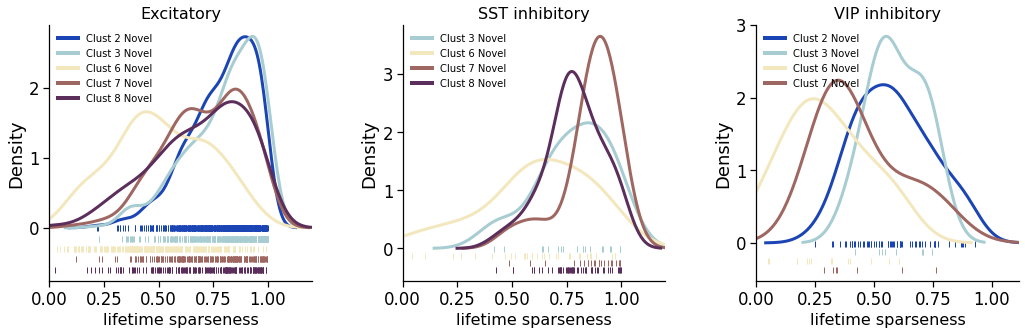

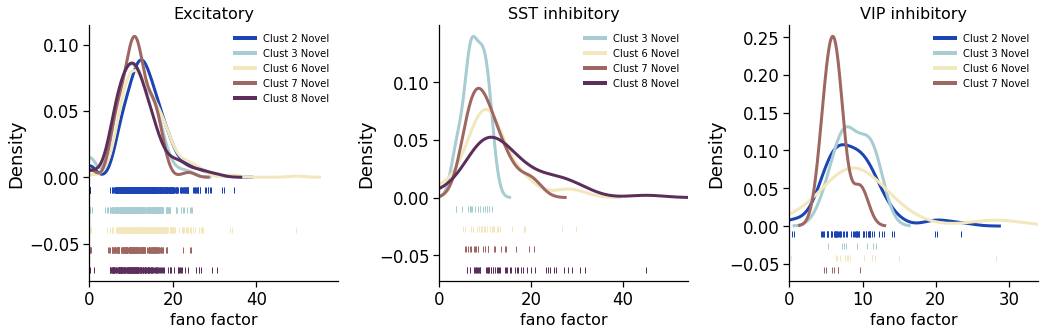

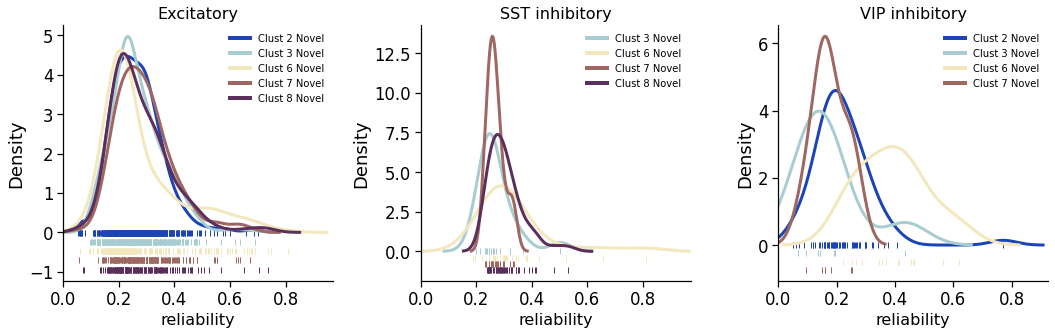

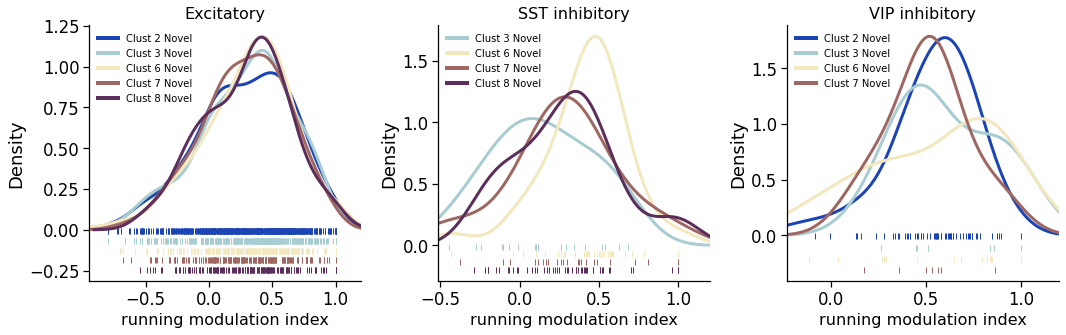

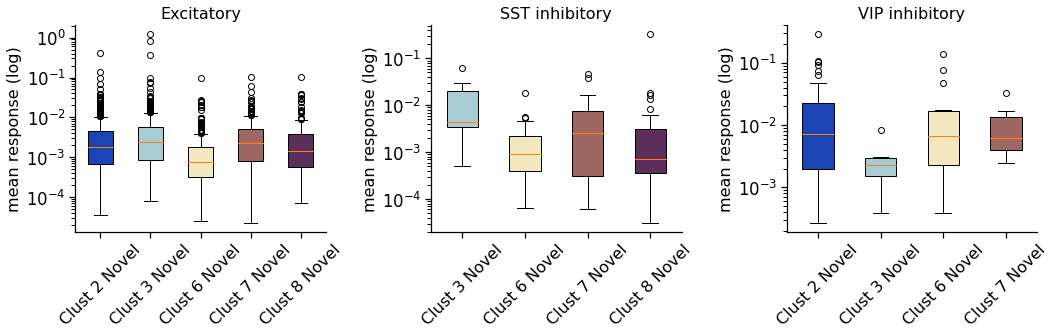

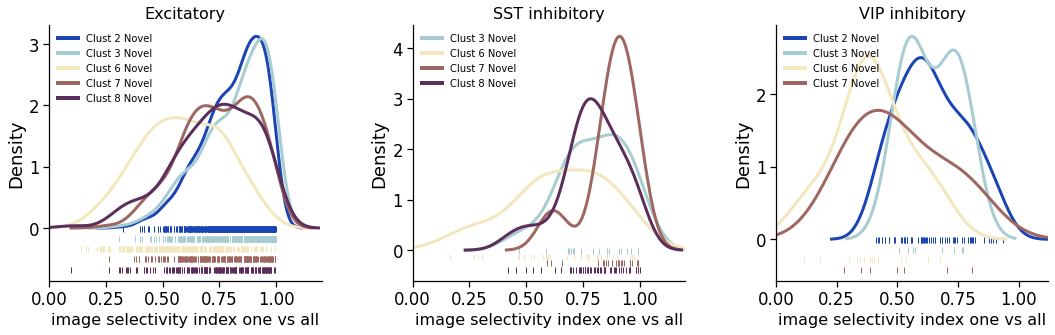

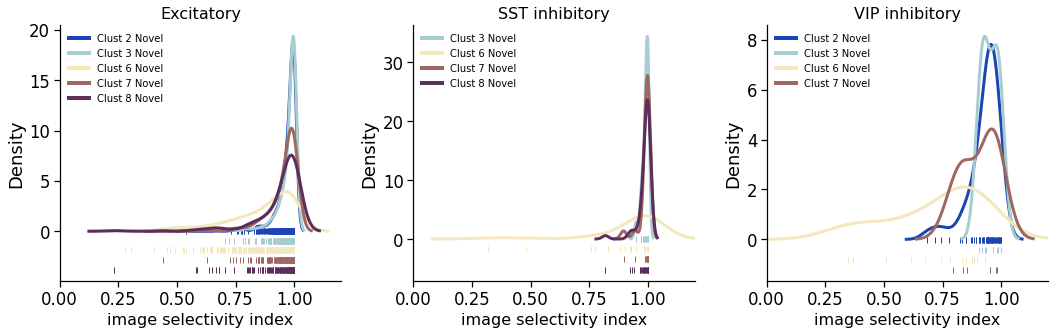

In [81]:
import pandas as pd
import re
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from itertools import combinations
import pickle
from visual_behavior.dimensionality_reduction.clustering import plotting
from visual_behavior.dimensionality_reduction.clustering import processing

# Function to prepare data based on cluster_id, exp_level, and cre_line
def prepare_data(cluster_id, exp_level, cre_line, rm_f):
    tmp = cluster_df[(cluster_df.cluster_id == cluster_id) & (cluster_df.cre_line == cre_line)]
    cids = tmp.cell_specimen_id.values
    return df.loc[cids][[rm_f]][[(rm_f, exp_level)]].values

# Function to plot kernel density estimate and rug plot
def plot_kde_rugplot(ax, data, color, y_shift, linestyle='-'):
    ax = sns.kdeplot(np.squeeze(data), color=color, linewidth=3, linestyle=linestyle, ax=ax)
    ax.plot(data, [y_shift]*len(data), '|', color=color)
    ax.set_yscale('linear')
    return ax

def plot_response_boxplot(ax, data, colors, patch_artist=True, widths = 0.5):

    if ax is None:
        fig, ax = plt.subplots(1,1)
    
    data_without_nans = []
    for d in data:
        if len(d)!=0:
            nan_mask = np.isnan(d)
            # Remove NaN values from the array
            data_without_nans.append(d[~nan_mask])
   
    bplot = ax.boxplot(np.squeeze(data_without_nans).T, patch_artist=patch_artist, widths=widths)
    
    # change color
    for patch, color in zip(bplot['boxes'], colors):
        patch.set_facecolor(color)
    
    ax.set_yscale('log')
    plt.tight_layout()
    return ax

# Function to plot cluster rug plots
def plot_cluster_rugplots(ax, cre_line, cluster_ids, exp_levels, rm_f, linestyles=None, test='MW', colors = []):
    custom_lines = []
    labels = []
    all_data = []
    all_colors = []
    # colors = gvt.project_colors()
    y_shift_base = -0.01
    x_shift = 0
    xmin, xmax = [0, 0]
    start = True
    fontsize = 16
    data_dict = {}  # Collect data for stats
    pattern = re.compile(r'response')
    for cluster_id, exp_level, linestyle in zip(cluster_ids, exp_levels, linestyles):
        data = prepare_data(cluster_id, exp_level, cre_line, rm_f)
        
        if len(data) > 1:
            
            match = pattern.search(rm_f)
            if match:
                all_data.append(data)
                all_colors.append(colors[cluster_id-1])
            else:
                ax = plot_kde_rugplot(ax, data, colors[cluster_id-1], y_shift_base, linestyle)
            if start:
                y_shift = ax.get_ylim()[0]
                start = False
            y_shift_base += y_shift  # Adjust the shift for the next level
            
            # Set x-axis limits based on data
            if not match:
                xmin = min(min(data), xmin)
                xmax = max(max(data), xmax)
                ax.set_xlim([xmin, xmax * 1.2])
                
            
            # Legend
            custom_lines.append(Line2D([0], [0], color=colors[cluster_id-1], linestyle=linestyle, lw=4))
            labels.append(f'Clust {cluster_id} {processing.get_experience_map(exp_level)}')
            
            # Collect data for stats
            group_name = f'clust {cluster_id} {processing.get_experience_map(exp_level)}'
            data_dict[group_name] = np.squeeze(data)
    
    if match:
        ax = plot_response_boxplot(ax, all_data, all_colors, patch_artist=True, widths = 0.5)
        ax.set_ylabel(rm_f.replace('_', ' ')+' (log)', fontsize = fontsize)
        ax.set_xticklabels(labels, fontsize=fontsize, rotation=45)
        ax.set_xlabel('')
    else:
        ax.legend(custom_lines, labels, fontsize=10, frameon=False)
        ax.set_xlabel(rm_f.replace('_', ' '), fontsize = fontsize)
        
    ax.set_title(processing.get_cre_line_map(cre_line), fontsize=fontsize)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    return ax, data_dict

# Your original code
df = rm_unstacked_all
suffix = '_changes'
folder = 'cluster_comparisons_changes'
# description = '_Familiar_vs_Novel_clusters_2_3_4_'
description = '_Novelty_coding_clusters'
rm_dict = {}

# Loop through rm_features
for index, rm_f in enumerate(rm_features):
    #cluster_ids_list = [3, 1, 2, 2]
    #exp_levels_list = ['Familiar', 'Novel 1', 'Novel 1', 'Novel >1']
    cluster_ids_list = [2,3,6,7,8]
    exp_levels_list = ['Novel 1', 'Novel 1', 'Novel 1', 'Novel 1','Novel 1']
    linestyles = ['-', '-', '-', '-', '-']
    
    fig, ax = plt.subplots(1, len(cre_lines), figsize=(5 * len(cre_lines), 5))
    ax = ax.ravel()

    cre_dict = {}
    for i, cre_line in enumerate(cre_lines):
        ax[i], cre_dict[cre_line] = plot_cluster_rugplots(ax[i], cre_line, cluster_ids_list, exp_levels_list, rm_f, linestyles, test='MW', colors=colors)

    plt.tight_layout()
    plt.show()
    filename = f'{rm_f}_{description}{suffix}.pdf'
    figname = os.path.join(save_dir,folder , filename) 
    fig.savefig(figname)
  
    rm_dict[rm_f] = cre_dict

    
if suffix == '_all':
    rm_dict_all = rm_dict.copy()
elif suffix == '_pref':
    rm_dict_pref = rm_dict.copy()
elif suffix == '_omissions':
    rm_dict_omissions = rm_dict.copy()
elif suffix == '_changes':
    rm_dict_changes = rm_dict.copy()
    
# Define the filename including the suffix
filename = os.path.join(save_dir, f"rm_dict{suffix}{description}.pkl")
# Pickle the dictionary to a file
with open(filename, 'wb') as file:
    pickle.dump(rm_dict, file)
    file.close()

In [65]:
folder


'cluster_comparisons_all_images'

In [82]:
from itertools import combinations
results_list = []
for rm_f in rm_features:
    for cre in cre_lines:
        data_dict = rm_dict_all[rm_f][cre]
        keys = list(data_dict.keys())
        for pair in combinations(keys, 2):
            data1 = data_dict[pair[0]]
            data2 = data_dict[pair[1]]
            u_stat, p_val = add_significance(data1, data2, test='MW')
            # print(f"Comparing {cre} {pair[0]} vs {pair[1]}:")
            # print(f"  Mann-Whitney U statistic: {u_stat}")
            # print(f"  p-value: {p_val}")

            # Append results to the list
            result = {
                'CRE': cre,
                'Comparison': f"{pair[0]} vs {pair[1]}",
                'U_statistic': u_stat,
                'P_value': p_val,
                'metric': rm_f,
            }
            results_list.append(result)
# Convert the results list to a DataFrame
df_results = pd.DataFrame(results_list)
   

In [83]:
df_results[(df_results['P_value']<0.01) & 
           (df_results['metric']=='lifetime_sparseness')]

,CRE,Comparison,U_statistic,P_value,metric
1,Slc17a7-IRES2-Cre,clust 2 Novel vs clust 6 Novel,136735.0,3.191221e-58,lifetime_sparseness
2,Slc17a7-IRES2-Cre,clust 2 Novel vs clust 7 Novel,77021.0,4.447372e-07,lifetime_sparseness
3,Slc17a7-IRES2-Cre,clust 2 Novel vs clust 8 Novel,68242.0,1.077365e-07,lifetime_sparseness
4,Slc17a7-IRES2-Cre,clust 3 Novel vs clust 6 Novel,84458.0,1.639552e-49,lifetime_sparseness
5,Slc17a7-IRES2-Cre,clust 3 Novel vs clust 7 Novel,48801.0,8.452746e-08,lifetime_sparseness
6,Slc17a7-IRES2-Cre,clust 3 Novel vs clust 8 Novel,43261.0,1.770114e-08,lifetime_sparseness
7,Slc17a7-IRES2-Cre,clust 6 Novel vs clust 7 Novel,13259.0,1.989204e-21,lifetime_sparseness
8,Slc17a7-IRES2-Cre,clust 6 Novel vs clust 8 Novel,13130.0,3.081252e-15,lifetime_sparseness
13,Sst-IRES-Cre,clust 6 Novel vs clust 7 Novel,128.0,6.651875e-05,lifetime_sparseness
14,Sst-IRES-Cre,clust 6 Novel vs clust 8 Novel,467.0,1.439572e-03,lifetime_sparseness


#### Working on panel i figure 4

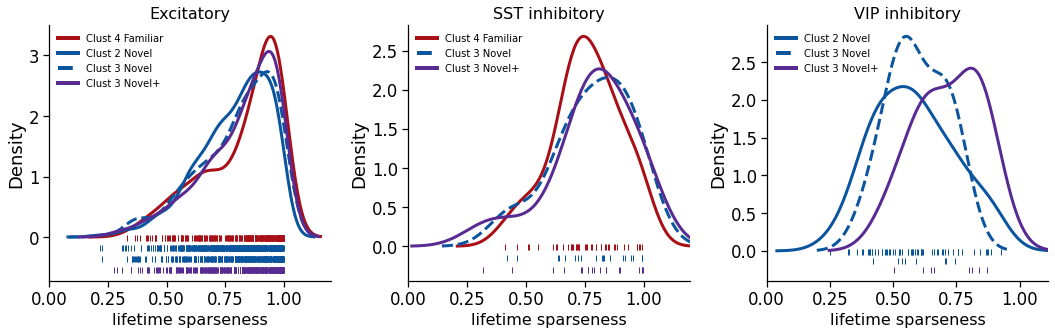

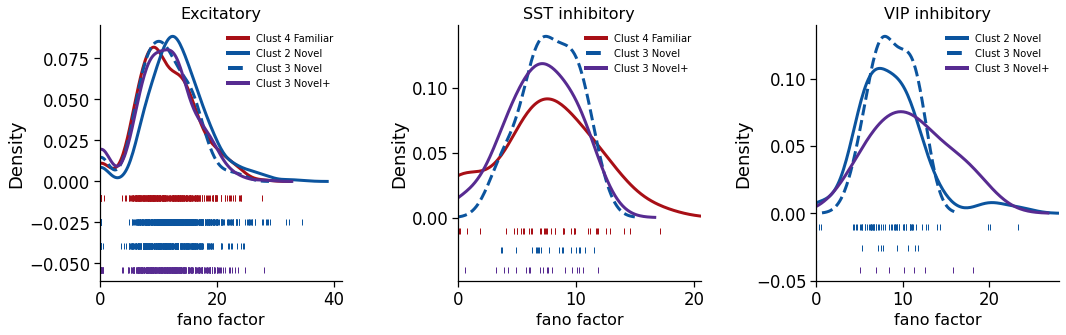

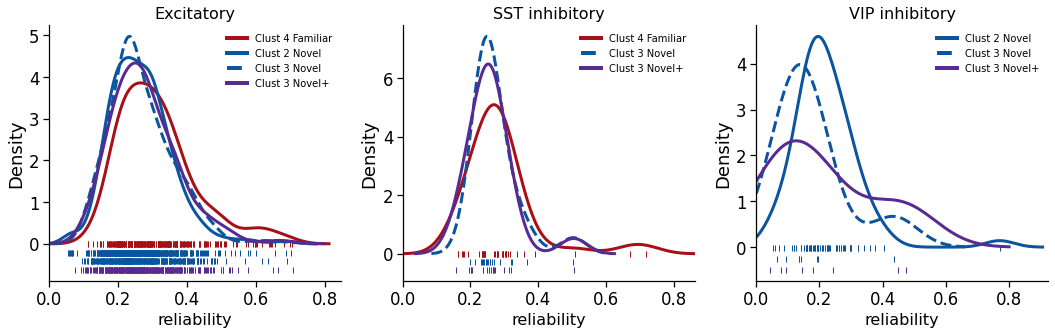

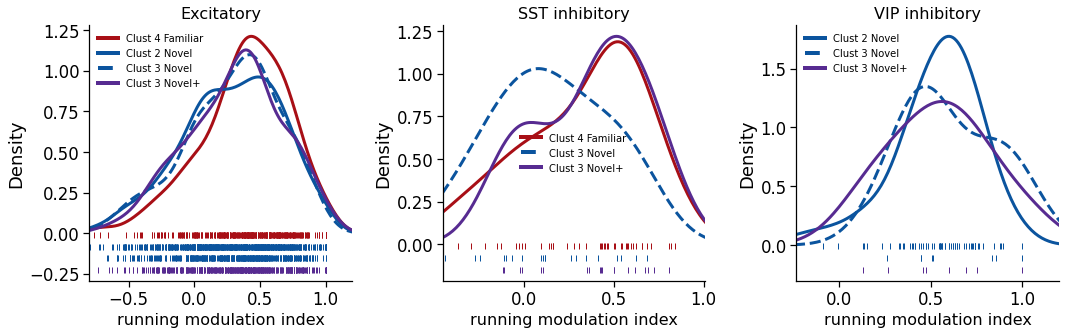

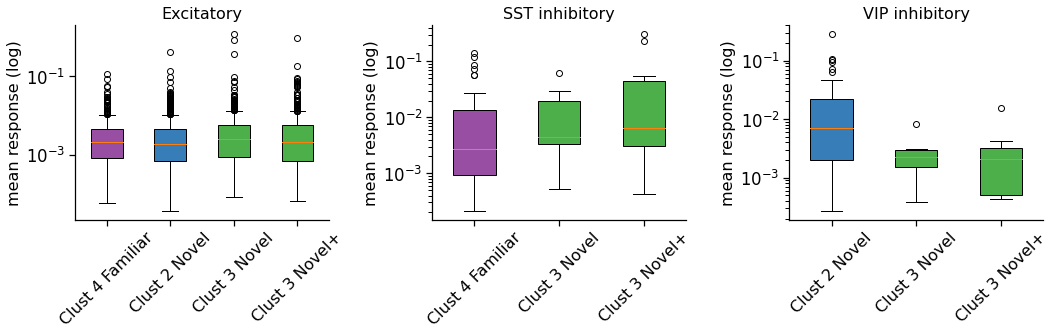

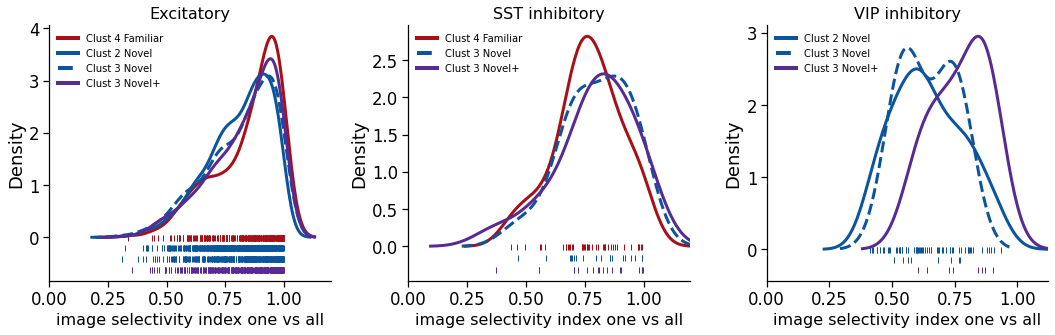

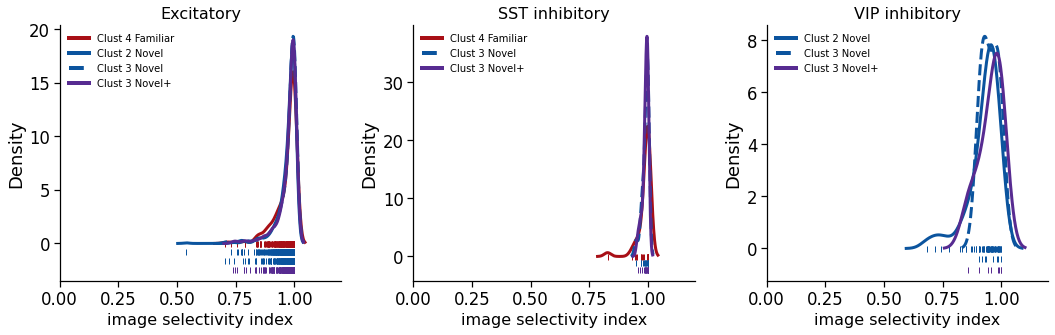

In [99]:

# Function to prepare data based on cluster_id, exp_level, and cre_line
def prepare_data(cluster_id, exp_level, cre_line, rm_f):
    tmp = cluster_df[(cluster_df.cluster_id == cluster_id) & (cluster_df.cre_line == cre_line)]
    cids = tmp.cell_specimen_id.values
    return df.loc[cids][[rm_f]][[(rm_f, exp_level)]].values

# Function to plot kernel density estimate and rug plot
def plot_kde_rugplot(ax, data, color, y_shift, linestyle='-'):
    ax = sns.kdeplot(np.squeeze(data), color=color, linewidth=3, linestyle=linestyle, ax=ax)
    ax.plot(data, [y_shift]*len(data), '|', color=color)
    ax.set_yscale('linear')
    return ax

def plot_response_boxplot(ax, data, colors, patch_artist=True, widths = 0.5):

    if ax is None:
        fig, ax = plt.subplots(1,1)
    
    data_without_nans = []
    for d in data:
        if len(d)!=0:
            nan_mask = np.isnan(d)
            # Remove NaN values from the array
            data_without_nans.append(d[~nan_mask])
   
    bplot = ax.boxplot(np.squeeze(data_without_nans).T, patch_artist=patch_artist, widths=widths)
    
    # change color
    for patch, color in zip(bplot['boxes'], colors):
        patch.set_facecolor(color)
    
    ax.set_yscale('log')
    plt.tight_layout()
    return ax

# Function to plot cluster rug plots
def plot_cluster_rugplots(ax, cre_line, cluster_ids, exp_levels, rm_f, linestyles=None, test='MW', colors = []):
    custom_lines = []
    labels = []
    all_data = []
    all_colors = []
    colors = gvt.project_colors()
    
    y_shift_base = -0.01
    x_shift = 0
    xmin, xmax = [0, 0]
    start = True
    fontsize = 16
    data_dict = {}  # Collect data for stats
    pattern = re.compile(r'response')
    for cluster_id, exp_level, linestyle in zip(cluster_ids, exp_levels, linestyles):
        data = prepare_data(cluster_id, exp_level, cre_line, rm_f)
        
        if len(data) > 1:
            
            match = pattern.search(rm_f)
            if match:
                all_data.append(data)
                all_colors.append(colors[cluster_id-1])
            else:
                ax = plot_kde_rugplot(ax, data, colors[exp_level], y_shift_base, linestyle)
            if start:
                y_shift = ax.get_ylim()[0]
                start = False
            y_shift_base += y_shift  # Adjust the shift for the next level
            
            # Set x-axis limits based on data
            if not match:
                xmin = min(min(data), xmin)
                xmax = max(max(data), xmax)
                ax.set_xlim([xmin, xmax * 1.2])
                
            
            # Legend
            custom_lines.append(Line2D([0], [0], color=colors[exp_level], linestyle=linestyle, lw=4))
            labels.append(f'Clust {cluster_id} {processing.get_experience_map(exp_level)}')
            
            # Collect data for stats
            group_name = f'clust {cluster_id} {processing.get_experience_map(exp_level)}'
            data_dict[group_name] = np.squeeze(data)
    
    if match:
        ax = plot_response_boxplot(ax, all_data, all_colors, patch_artist=True, widths = 0.5)
        ax.set_ylabel(rm_f.replace('_', ' ')+' (log)', fontsize = fontsize)
        ax.set_xticklabels(labels, fontsize=fontsize, rotation=45)
        ax.set_xlabel('')
    else:
        ax.legend(custom_lines, labels, fontsize=10, frameon=False)
        ax.set_xlabel(rm_f.replace('_', ' '), fontsize = fontsize)
        
    ax.set_title(processing.get_cre_line_map(cre_line), fontsize=fontsize)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    return ax, data_dict

# Your original code
df = rm_unstacked_all
suffix = '_pref'
folder = 'cluster_comparisons_pref_image'
description = '_Familiar_vs_Novel_clusters_2_3_4_'
rm_dict = {}

# Loop through rm_features
for index, rm_f in enumerate(rm_features):
    cluster_ids_list = [4, 2, 3, 3]
    exp_levels_list = ['Familiar', 'Novel 1', 'Novel 1', 'Novel >1']
    linestyles = ['-', '-', '--', '-', '-']
    
    fig, ax = plt.subplots(1, len(cre_lines), figsize=(5 * len(cre_lines), 5), )
    ax = ax.ravel()

    cre_dict = {}
    for i, cre_line in enumerate(cre_lines):
        ax[i], cre_dict[cre_line] = plot_cluster_rugplots(ax[i], cre_line, cluster_ids_list, exp_levels_list, rm_f, linestyles, test='MW', colors=colors)

    plt.tight_layout()
    plt.show()
    filename = f'{rm_f}_{description}{suffix}.pdf'
    figname = os.path.join(save_dir,folder , filename) 
    fig.savefig(figname)
  
    rm_dict[rm_f] = cre_dict

    
if suffix == '_all':
    rm_dict_all = rm_dict.copy()
elif suffix == '_pref':
    rm_dict_pref = rm_dict.copy()
elif suffix == '_omissions':
    rm_dict_omissions = rm_dict.copy()
elif suffix == '_changes':
    rm_dict_changes = rm_dict.copy()
    
# Define the filename including the suffix
filename = os.path.join(save_dir, f"rm_dict{suffix}{description}.pkl")
# Pickle the dictionary to a file
with open(filename, 'wb') as file:
    pickle.dump(rm_dict, file)
    file.close()

In [102]:
from itertools import combinations
results_list = []
for rm_f in rm_features:
    for cre in cre_lines:
        data_dict = rm_dict_all[rm_f][cre]
        keys = list(data_dict.keys())
        for pair in combinations(keys, 2):
            data1 = data_dict[pair[0]]
            data2 = data_dict[pair[1]]
            u_stat, p_val = add_significance(data1, data2, test='MW')
            # print(f"Comparing {cre} {pair[0]} vs {pair[1]}:")
            # print(f"  Mann-Whitney U statistic: {u_stat}")
            # print(f"  p-value: {p_val}")

            # Append results to the list
            result = {
                'CRE': cre,
                'Comparison': f"{pair[0]} vs {pair[1]}",
                'U_statistic': u_stat,
                'P_value': p_val,
                'metric': rm_f,
            }
            results_list.append(result)
# Convert the results list to a DataFrame
df_results = pd.DataFrame(results_list)
   

In [104]:
df_results[(df_results['P_value']<0.05) ] # df_results['metric']=='image_selectivity_index_one_vs_all')

,CRE,Comparison,U_statistic,P_value,metric
0,Slc17a7-IRES2-Cre,clust 4 Familiar vs clust 2 Novel,111119.0,5.431974e-05,lifetime_sparseness
1,Slc17a7-IRES2-Cre,clust 4 Familiar vs clust 3 Novel,65048.0,2.035223e-02,lifetime_sparseness
4,Slc17a7-IRES2-Cre,clust 2 Novel vs clust 3 Novel+,101432.0,1.612181e-03,lifetime_sparseness
10,Vip-IRES-Cre,clust 2 Novel vs clust 3 Novel+,126.0,2.285548e-02,lifetime_sparseness
12,Slc17a7-IRES2-Cre,clust 4 Familiar vs clust 2 Novel,75762.0,2.312203e-07,fano_factor
15,Slc17a7-IRES2-Cre,clust 2 Novel vs clust 3 Novel,142936.0,1.870046e-10,fano_factor
16,Slc17a7-IRES2-Cre,clust 2 Novel vs clust 3 Novel+,140872.0,3.680626e-09,fano_factor
24,Slc17a7-IRES2-Cre,clust 4 Familiar vs clust 2 Novel,119249.0,7.570093e-10,reliability
25,Slc17a7-IRES2-Cre,clust 4 Familiar vs clust 3 Novel,72821.0,1.147166e-07,reliability
26,Slc17a7-IRES2-Cre,clust 4 Familiar vs clust 3 Novel+,69981.0,2.528725e-05,reliability


In [134]:
df_results.Comparison.unique()

array(['clust 4 Familiar vs clust 2 Novel',
       'clust 4 Familiar vs clust 3 Novel',
       'clust 4 Familiar vs clust 3 Novel+',
       'clust 2 Novel vs clust 3 Novel',
       'clust 2 Novel vs clust 3 Novel+',
       'clust 3 Novel vs clust 3 Novel+'], dtype=object)

### Table of significance

In [124]:
from itertools import combinations
results_list = []
for rm_f in rm_features:
    for cre in cre_lines:
        data_dict = rm_dict_all[rm_f][cre]
        keys = list(data_dict.keys())
        for pair in combinations(keys, 2):
            data1 = data_dict[pair[0]]
            data2 = data_dict[pair[1]]
            u_stat, p_val = add_significance(data1, data2, test='MW')
            # print(f"Comparing {cre} {pair[0]} vs {pair[1]}:")
            # print(f"  Mann-Whitney U statistic: {u_stat}")
            # print(f"  p-value: {p_val}")

            # Append results to the list
            result = {
                'CRE': cre,
                'pair1': f"{pair[0]}", 
                'pair2': f"{pair[1]}",
                'U_statistic': u_stat,
                'P_value': p_val,
                'metric': rm_f,
            }
            results_list.append(result)
# Convert the results list to a DataFrame
df = pd.DataFrame(results_list)
   

In [128]:
df

,CRE,pair1,pair2,U_statistic,P_value,metric,significance
0,Slc17a7-IRES2-Cre,clust 4 Familiar,clust 2 Novel,111119.0,0.000054,lifetime_sparseness,True
1,Slc17a7-IRES2-Cre,clust 4 Familiar,clust 3 Novel,65048.0,0.020352,lifetime_sparseness,True
2,Slc17a7-IRES2-Cre,clust 4 Familiar,clust 3 Novel+,61733.0,0.294607,lifetime_sparseness,False
3,Slc17a7-IRES2-Cre,clust 2 Novel,clust 3 Novel,108617.0,0.132410,lifetime_sparseness,False
4,Slc17a7-IRES2-Cre,clust 2 Novel,clust 3 Novel+,101432.0,0.001612,lifetime_sparseness,True
...,...,...,...,...,...,...,...
79,Sst-IRES-Cre,clust 4 Familiar,clust 3 Novel+,566.5,0.013880,image_selectivity_index,True
80,Sst-IRES-Cre,clust 3 Novel,clust 3 Novel+,183.0,0.953428,image_selectivity_index,False
81,Vip-IRES-Cre,clust 2 Novel,clust 3 Novel,212.0,0.519311,image_selectivity_index,False
82,Vip-IRES-Cre,clust 2 Novel,clust 3 Novel+,182.0,0.231416,image_selectivity_index,False


In [133]:
 df['pair2'].unique()

array(['clust 2 Novel', 'clust 3 Novel', 'clust 3 Novel+'], dtype=object)

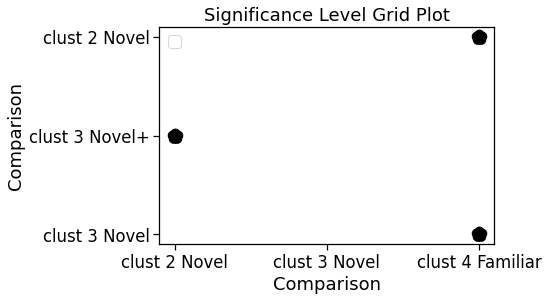

In [154]:
# Create a new column for significance indicator

df['significance'] = df['P_value'] < 0.05

# Set up the grid plot
fig, ax = plt.subplots()

#for feature in df['metric'].unique():
feature = 'lifetime_sparseness'
comparison = np.sort(np.unique([df['pair1'].unique(), df['pair2'].unique()]))
for pair1 in comparison:
    for pair2 in comparison:
        subset = df[(df['metric'] == feature) & (df['pair1'] == pair1) &
                (df['pair2'] == pair2) & (df['CRE'] == cre_lines[0])]
        
    # Plot the point with significance indicator
        if not subset.empty:
            marker = '*' if subset['significance'].values[0] else ''
            ax.scatter(subset['pair1'], subset['pair2'], marker=marker, color='black', linewidths=10, label=f'{pair1}')
            
        else:
            ax.scatter(0, 0, marker='',label=f'{pair1}')

# Customize the plot
ax.grid(False)
ax.legend([])
ax.set_xlabel('Comparison')
ax.set_ylabel('Comparison')
ax.set_title('Significance Level Grid Plot')
plt.show()

In [150]:
np.sort(comparison)

array(['clust 2 Novel', 'clust 3 Novel', 'clust 3 Novel+',
       'clust 4 Familiar'], dtype=object)

In [153]:
subset


,CRE,pair1,pair2,U_statistic,P_value,metric,significance


In [250]:

df = rm_unstacked_all
suffix='_all'
folder = 'distributions_all_images'

for index, rm_f in enumerate(rm_features):
    for cluster_id_1 in range(1,13): #5
        for cluster_id_2 in range(1,13): #9
            for exp_level_1 in experience_levels:
                for exp_level_2 in experience_levels:
                        
                    fig,ax = plt.subplots(1,3, figsize=(15,7), )#sharex=True)
                    ax=ax.ravel()
                    for c,cre in enumerate(cre_lines):
                        
                        # get data from first cluster
                        tmp = cluster_df[(cluster_df.cluster_id==cluster_id_1-1) & (cluster_df.cre_line==cre)]
                        cids = tmp.cell_specimen_id.values
                        try:
                            data = df.loc[cids][[rm_f]][[(rm_f,  exp_level_1)]]
                            data_array1=data.values

                        except:
                            data_array1 =[]
                            print('no cells')
                            
                        # get data from second cluster    
                        tmp = cluster_df[(cluster_df.cluster_id==cluster_id_2-1) & (cluster_df.cre_line==cre)]
                        cids = tmp.cell_specimen_id.values
                        try: 
                            data = df.loc[cids][[rm_f]][[(rm_f,  exp_level_2)]]
                            data_array2=data.values
                        except:
                            data_array2 = []
                            print('no cells')
                            
                        # change to one sample test if comparing cells within the same cluster
                        if cluster_id_1 == cluster_id_2:
                            test='W'
                        else:
                            test='MW'
                                     
                        # plot figure
                        if rm_f == 'mean_response':
                            
                            plot_boxplot(data_array1, data_array2, exp_level_1, exp_level_2, 
                                         ax = ax[c], patch_artist=True, widths = 0.5, test=test, suffix=suffix)
                        else:
                            plot_distribution(data_array1, data_array2, exp_level_1, exp_level_2, 
                                          ax = ax[c], bins=30, density=True, label=False, test=test, suffix=suffix)
                    if exp_level_2 == 'Novel >1':
                        exp_level_2 = 'Novel+'
                    if exp_level_1 == 'Novel >1':
                        exp_level_1 = 'Novel+'
                    plt.suptitle(f'cluster {cluster_id_1} and cluster {cluster_id_2}')
                    plt.tight_layout()
                    # figname
                    filename = f'{rm_f}_{cluster_id_1}_{cluster_id_2}_{exp_level_1}_{exp_level_2}.png'
                    figname = os.path.join(save_dir,folder , filename) 
                    fig.savefig(figname)
                    plt.close('all')


C:\Users\iryna.yavorska\Anaconda3\envs\vba\lib\site-packages\scipy\stats\morestats.py:3141: UserWarning: Exact p-value calculation does not work if there are ties. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "
C:\Users\iryna.yavorska\Anaconda3\envs\vba\lib\site-packages\scipy\stats\morestats.py:3155: UserWarning: Sample size too small for normal approximation.
  warnings.warn("Sample size too small for normal approximation.")


no cells


C:\Users\iryna.yavorska\Anaconda3\envs\vba\lib\site-packages\numpy\lib\histograms.py:906: RuntimeWarning: invalid value encountered in true_divide
  return n/db/n.sum(), bin_edges


no cells
no cells
no cells
no cells
no cells
no cells
no cells
no cells
no cells
no cells
no cells
no cells
no cells
no cells
no cells
no cells
no cells
no cells
no cells
no cells
no cells
no cells
no cells
no cells
no cells
no cells
no cells
no cells
no cells
no cells
no cells
no cells
no cells
no cells
no cells
no cells
no cells
no cells
no cells
no cells
no cells
no cells
no cells
no cells
no cells
no cells
no cells
no cells
no cells
no cells
no cells
no cells
no cells
no cells
no cells
no cells
no cells
no cells
no cells
no cells
no cells
no cells
no cells
no cells
no cells
no cells
no cells
no cells
no cells
no cells
no cells
no cells
no cells
no cells
no cells
no cells
no cells
no cells
no cells
no cells
no cells
no cells
no cells
no cells
no cells
no cells
no cells
no cells
no cells
no cells
no cells
no cells
no cells
no cells
no cells
no cells
no cells
no cells
no cells
no cells
no cells
no cells
no cells
no cells
no cells
no cells
no cells
no cells
no cells
no cells
no cells
n